数据概览:
           日期  唯一编号  性别  年龄   C反应蛋白  N末端B型钠尿肽原测定  α羟基丁酸脱氢酶  中性粒细胞绝对值    乳酸脱氢酶  \
0  2021-10-11     1   1  64    2.04        607.5     676.0      7.71   686.85   
1  2021-10-12     1   1  64    4.40       2475.2     926.0      6.47   904.60   
2  2021-10-13     1   1  64   11.50       2855.7     596.0      7.49   604.00   
3  2021-11-24     3   1  47   47.30       2883.8    2042.0     21.33  1545.50   
4  2021-11-26     3   1  47  121.20       3600.0    1060.0     14.15  1177.60   

   二氧化碳  ...  甘油三酯   白细胞   白蛋白  直接胆红素  红细胞沉降率  谷丙转氨酶  间接胆红素  高密度脂蛋白  同型半胱氨酸  \
0  28.8  ...  1.53   3.7  41.9    4.8      11   31.5   15.4    0.87    22.4   
1  23.7  ...  2.61   5.0  40.6    5.8      10   43.0   15.4    0.87    19.1   
2  22.1  ...  1.58  71.7  39.4    3.6      39   31.5    6.7    0.87    15.9   
3  22.2  ...  0.52   3.8  39.8    6.5       7   89.0   15.6    1.33    24.6   
4  26.0  ...  1.58   2.2  32.1    4.2      30   80.0    7.8    0.95    35.4   

   住院日序号  
0      1  
1      2  

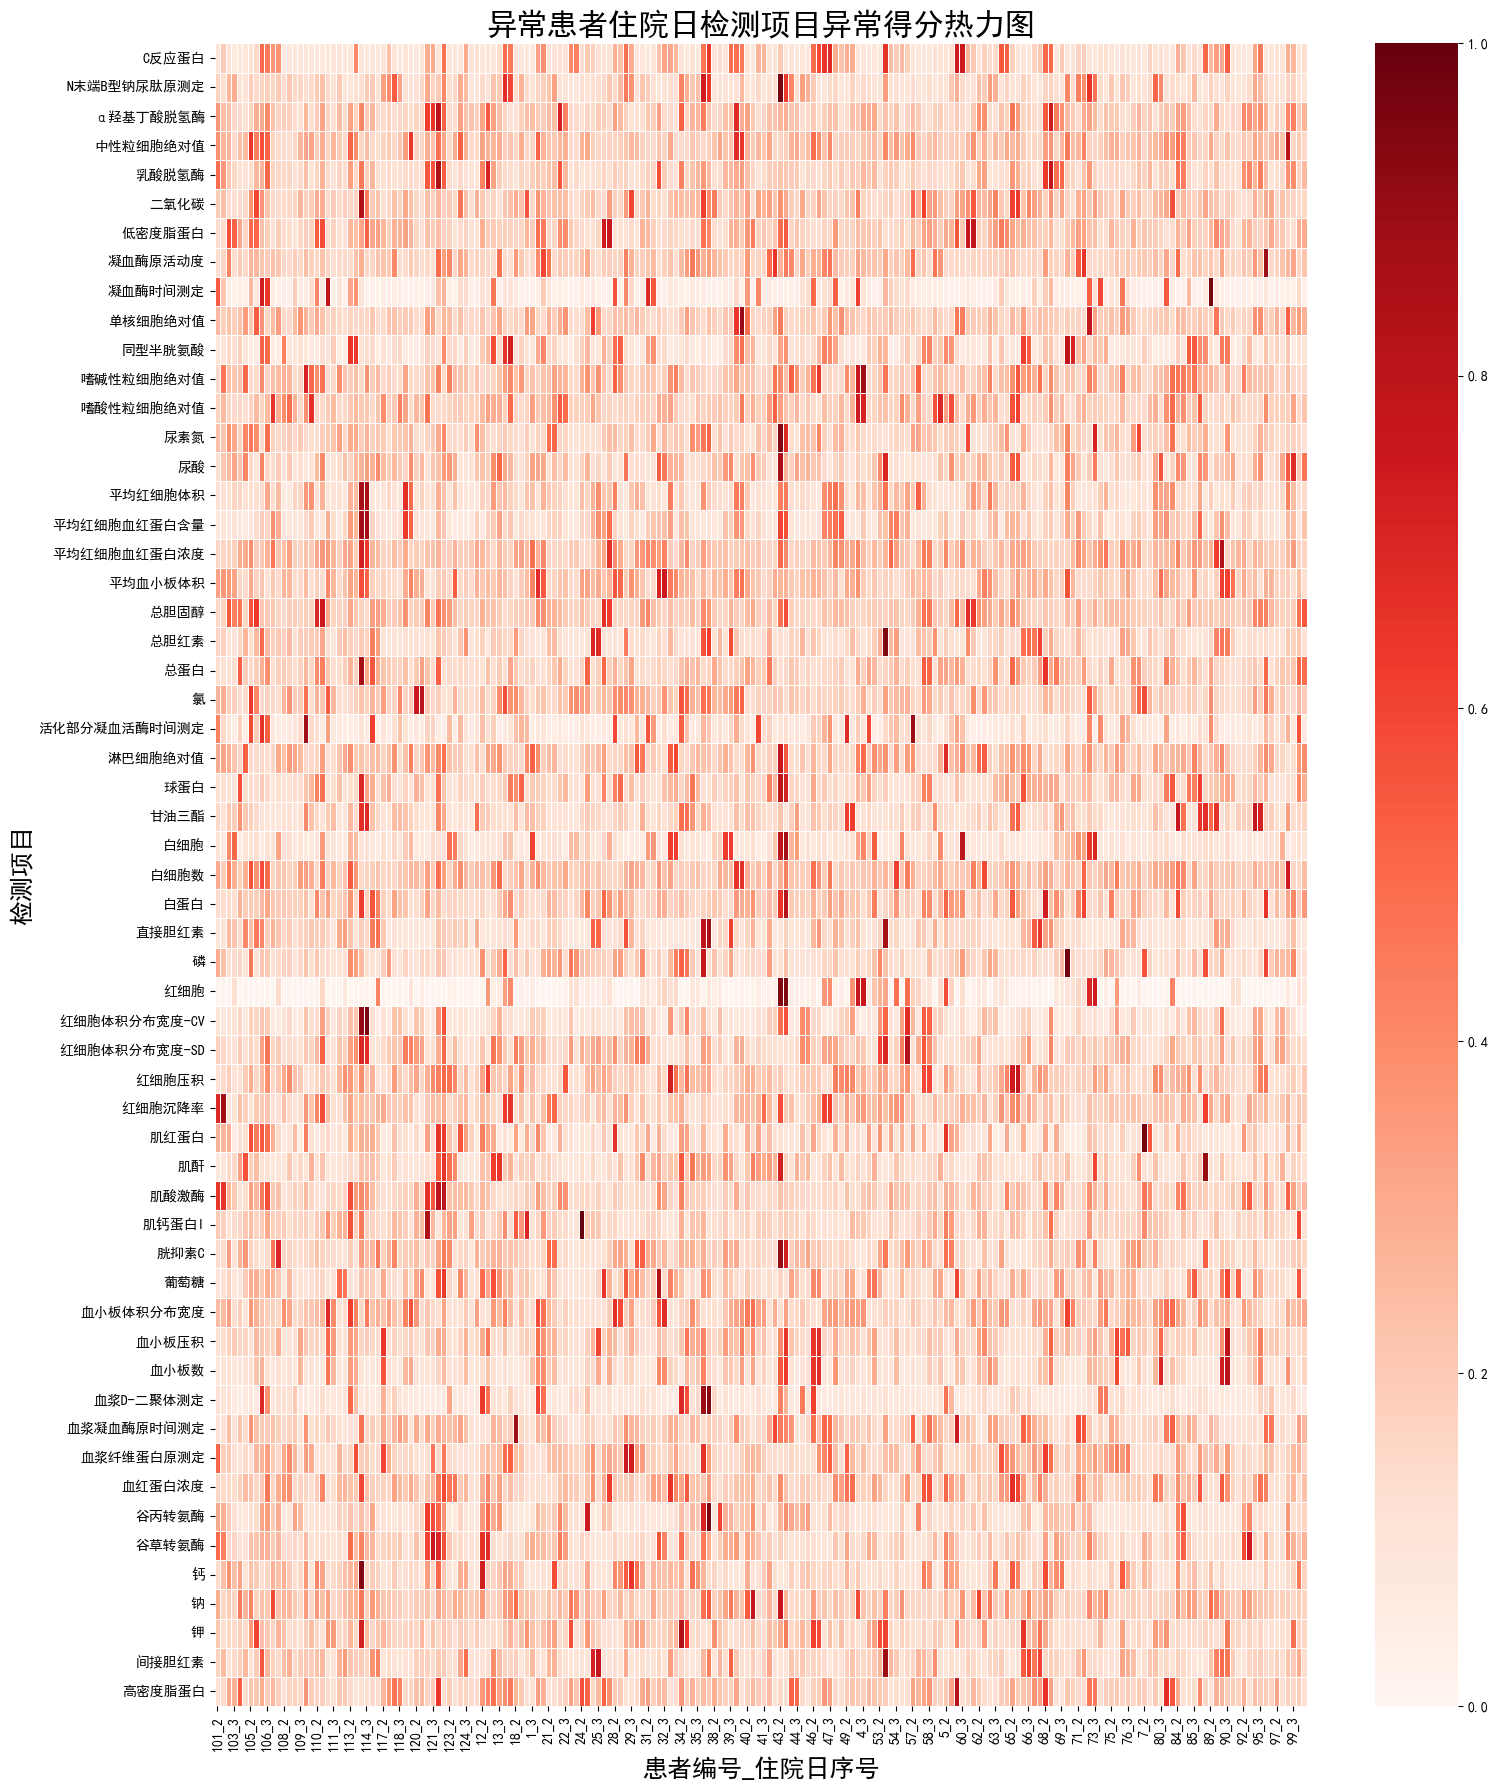

热力图已保存到: D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\anomaly_heatmap.png


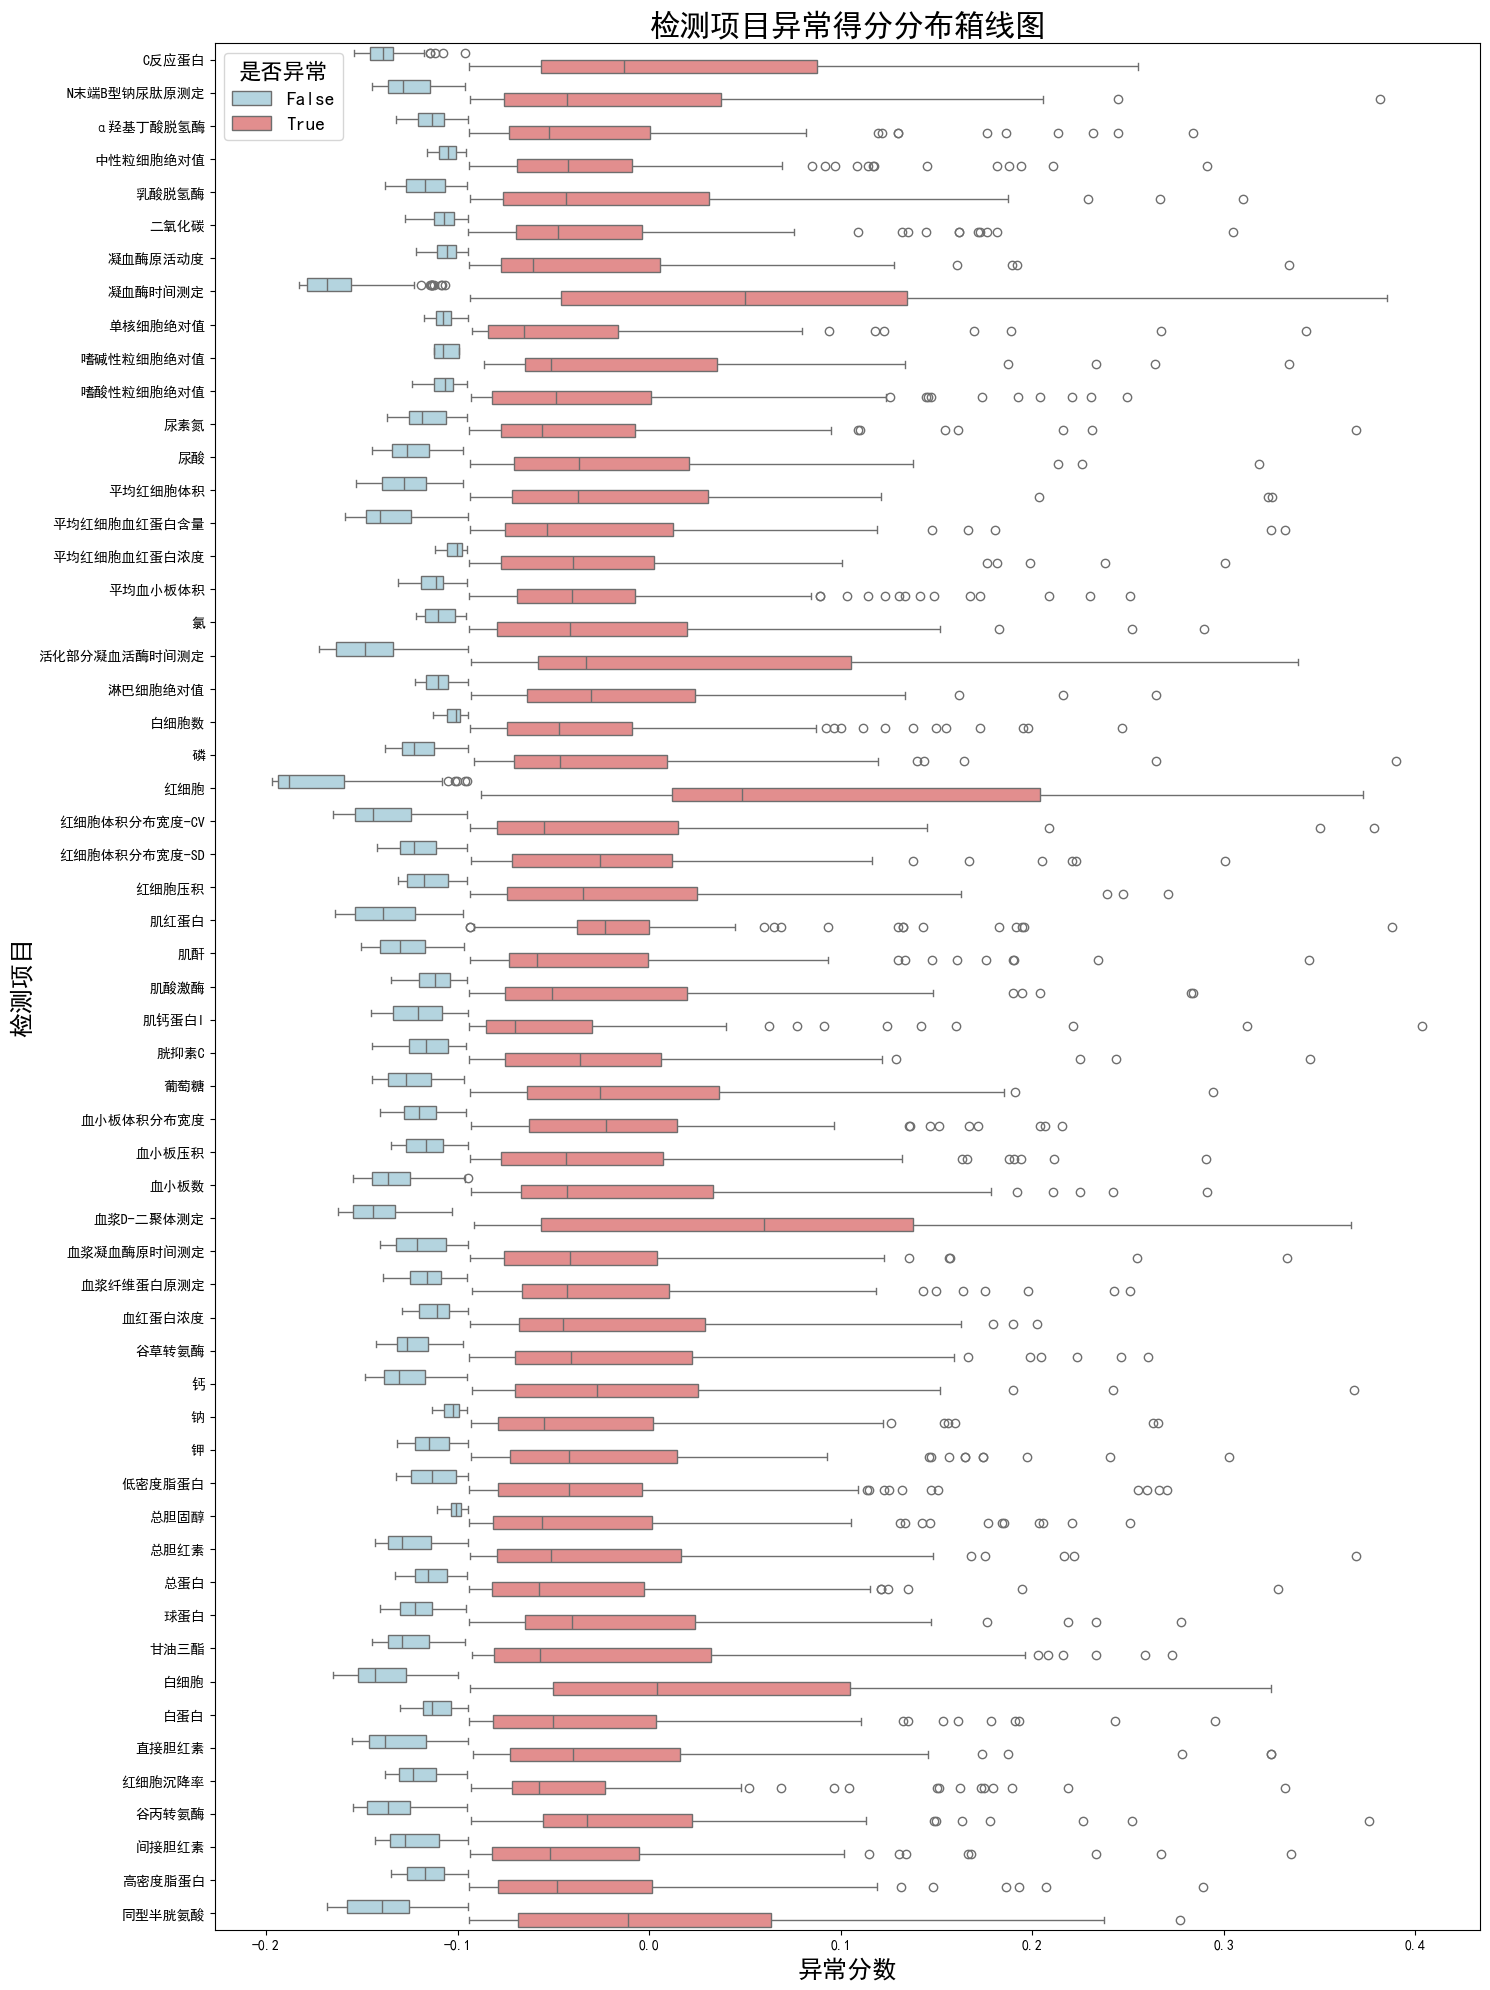

箱线图已保存到: D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\anomaly_boxplot.png


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from matplotlib.font_manager import FontProperties

# ==========================
# 1. 数据加载与预处理
# ==========================

# 定义文件路径
data_path = r'D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\data_GAN.csv'

# 读取CSV文件
data = pd.read_csv(data_path)

# 查看数据基本信息
print("数据概览:")
print(data.head())
print("\n数据描述:")
print(data.describe())
print("\n数据类型:")
print(data.dtypes)

# 排除非特征列
exclude_cols = ['唯一编号', '日期', '住院日序号', '性别', '年龄']
feature_cols = [col for col in data.columns if col not in exclude_cols]

# 确保特征列为数值型，并处理缺失值（填充为0或其他策略）
data[feature_cols] = data[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# 查看缺失值情况
print("\n缺失值情况:")
print(data[feature_cols].isnull().sum())

# 获取唯一的患者编号和检测项目
unique_ids = data['唯一编号'].unique()
unique_projects = feature_cols  # 每个特征列代表一个检测项目

# ==========================
# 2. 构建滑动窗口特征
# ==========================

# 定义滑动窗口大小
window_size = 2  # 2天滑动窗口

# 初始化一个空的列表来存储窗口特征
window_features = []

# 遍历每个患者
for uid in unique_ids:
    patient_data = data[data['唯一编号'] == uid].sort_values('住院日序号')
    patient_data = patient_data.reset_index(drop=True)
    num_days = patient_data.shape[0]

    # 对每个检测项目应用滑动窗口
    for project in unique_projects:
        project_values = patient_data[project].values

        # 创建滑动窗口
        for i in range(num_days - window_size + 1):
            window = project_values[i:i + window_size]
            day1, day2 = window

            # 计算特征
            change = day2 - day1
            mean_val = np.mean(window)
            var_val = np.var(window)

            # 对应的住院日序号（窗口的第二天）
            hospital_day = patient_data.loc[i + window_size - 1, '住院日序号']

            # 存储特征
            window_features.append({
                '唯一编号': uid,
                '检测项目': project,
                '住院日序号': hospital_day,
                'change': change,
                'mean_val': mean_val,
                'var_val': var_val
            })

# 转换为DataFrame
features_df = pd.DataFrame(window_features)

print("\n滑动窗口特征数据概览:")
print(features_df.head())
print("\n滑动窗口特征数据描述:")
print(features_df.describe())

# ==========================
# 3. 训练孤立森林模型并计算异常分数
# ==========================

# 初始化一个空的列表来存储异常分数
anomaly_scores_list = []

# 获取所有检测项目
projects = features_df['检测项目'].unique()

# 遍历每个检测项目
for project in projects:
    print(f"处理项目: {project}")

    project_data = features_df[features_df['检测项目'] == project]

    # 提取特征
    feature_columns = ['change', 'mean_val', 'var_val']
    X = project_data[feature_columns].values

    # 检查是否有足够的数据点
    if len(X) < 2:
        print(f"项目 {project} 的数据点不足，跳过。\n")
        continue

    # 训练孤立森林模型
    iso = IsolationForest(n_estimators=100, contamination='auto', random_state=123)
    iso.fit(X)

    # 计算异常分数（决策函数越小，越异常）
    scores = -iso.decision_function(X)  # 转换为越大越异常

    # 添加异常分数到DataFrame
    project_anomaly = project_data.copy()
    project_anomaly['异常分数'] = scores

    anomaly_scores_list.append(project_anomaly)

    print(f"项目 {project} 的异常分数计算完成。\n")

# 合并所有项目的异常分数
if anomaly_scores_list:
    anomaly_scores_df = pd.concat(anomaly_scores_list, ignore_index=True)
    print("所有项目的异常分数已合并。")
    print(f"总异常分数数据点: {anomaly_scores_df.shape[0]}")
else:
    print("没有项目的异常分数被计算。")
    anomaly_scores_df = pd.DataFrame()

# ==========================
# 4. 标准化异常分数
# ==========================

if not anomaly_scores_df.empty:
    scaler = MinMaxScaler()
    anomaly_scores_df['异常分数标准化'] = scaler.fit_transform(anomaly_scores_df[['异常分数']])

    print("\n标准化后的异常分数数据概览:")
    print(anomaly_scores_df.head())
else:
    print("异常分数数据框为空，跳过标准化步骤。")

# ==========================
# 5. 创建 '唯一编号_住院日' 列
# ==========================

if not anomaly_scores_df.empty:
    anomaly_scores_df['唯一编号_住院日'] = anomaly_scores_df['唯一编号'].astype(str) + '_' + anomaly_scores_df['住院日序号'].astype(str)
    print("\n创建 '唯一编号_住院日' 列完成。")
    print(anomaly_scores_df[['唯一编号', '住院日序号', '唯一编号_住院日']].head())
else:
    print("异常分数数据框为空，跳过创建 '唯一编号_住院日' 列。")

# ==========================
# 6. 保存异常分数
# ==========================

# 定义保存路径
save_dir = r'D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总'

# 确保保存目录存在
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"创建保存目录: {save_dir}")

# 定义保存文件路径
save_path = os.path.join(save_dir, 'anomaly_scores_df.csv')

# 保存为CSV文件
anomaly_scores_df.to_csv(save_path, index=False)
print(f"异常分数已保存到: {save_path}")

# ==========================
# 7. 可视化（可选）
# ==========================

if not anomaly_scores_df.empty:
    # 设置中文字体（SimHei）和解决负号显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 生成热力图
    plt.figure(figsize=(16, 18))
    # 创建一个新的列来表示患者编号和住院日序号的组合
    anomaly_scores_df['唯一编号_住院日'] = anomaly_scores_df['唯一编号'].astype(str) + '_' + anomaly_scores_df['住院日序号'].astype(str)
    heatmap_data = anomaly_scores_df.pivot(index='检测项目', columns='唯一编号_住院日', values='异常分数标准化')

    sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, linecolor='white')
    plt.title('异常患者住院日检测项目异常得分热力图', fontsize=22)
    plt.xlabel('患者编号_住院日序号', fontsize=18)
    plt.ylabel('检测项目', fontsize=18)
    plt.tight_layout()

    # 保存热力图
    heatmap_save_path = os.path.join(save_dir, 'anomaly_heatmap.png')
    plt.savefig(heatmap_save_path, dpi=300)
    plt.show()  # 显示热力图
    plt.close()
    print(f"热力图已保存到: {heatmap_save_path}")

    # 生成箱线图（异常与正常对比）
    plt.figure(figsize=(15, 20))  # 调整箱线图尺寸

    # 根据异常分数中位数划分正常与异常
    median_score = anomaly_scores_df['异常分数'].median()
    anomaly_scores_df['是否异常'] = anomaly_scores_df['异常分数'] > median_score  # 按中位数划分正常与异常

    # 使用项目名称作为纵轴，异常分数作为横轴
    sns.boxplot(y='检测项目', x='异常分数', hue='是否异常', data=anomaly_scores_df, palette=['lightblue', 'lightcoral'])
    plt.title('检测项目异常得分分布箱线图', fontsize=22)
    plt.xlabel('异常分数', fontsize=18)
    plt.ylabel('检测项目', fontsize=18)
    plt.legend(title='是否异常', fontsize=14, title_fontsize=16)
    plt.tight_layout()

    # 保存箱线图
    boxplot_save_path = os.path.join(save_dir, 'anomaly_boxplot.png')
    plt.savefig(boxplot_save_path, dpi=300)
    plt.show()  # 显示箱线图
    plt.close()
    print(f"箱线图已保存到: {boxplot_save_path}")
else:
    print("异常分数数据框为空，跳过可视化步骤。")


Data Overview:
         Date  UniqueID  Gender  Age  C_reactive_protein  NT_proBNP  \
0  2021-10-11         1       1   64                2.04      607.5   
1  2021-10-12         1       1   64                4.40     2475.2   
2  2021-10-13         1       1   64               11.50     2855.7   
3  2021-11-24         3       1   47               47.30     2883.8   
4  2021-11-26         3       1   47              121.20     3600.0   

   Alpha_HBDH  Neutrophil_count      LDH   CO2  ...  Triglyceride  Leukocyte  \
0       676.0              7.71   686.85  28.8  ...          1.53        3.7   
1       926.0              6.47   904.60  23.7  ...          2.61        5.0   
2       596.0              7.49   604.00  22.1  ...          1.58       71.7   
3      2042.0             21.33  1545.50  22.2  ...          0.52        3.8   
4      1060.0             14.15  1177.60  26.0  ...          1.58        2.2   

   Albumin  Direct_bilirubin  ESR   ALT  Indirect_bilirubin   HDL  \
0     41

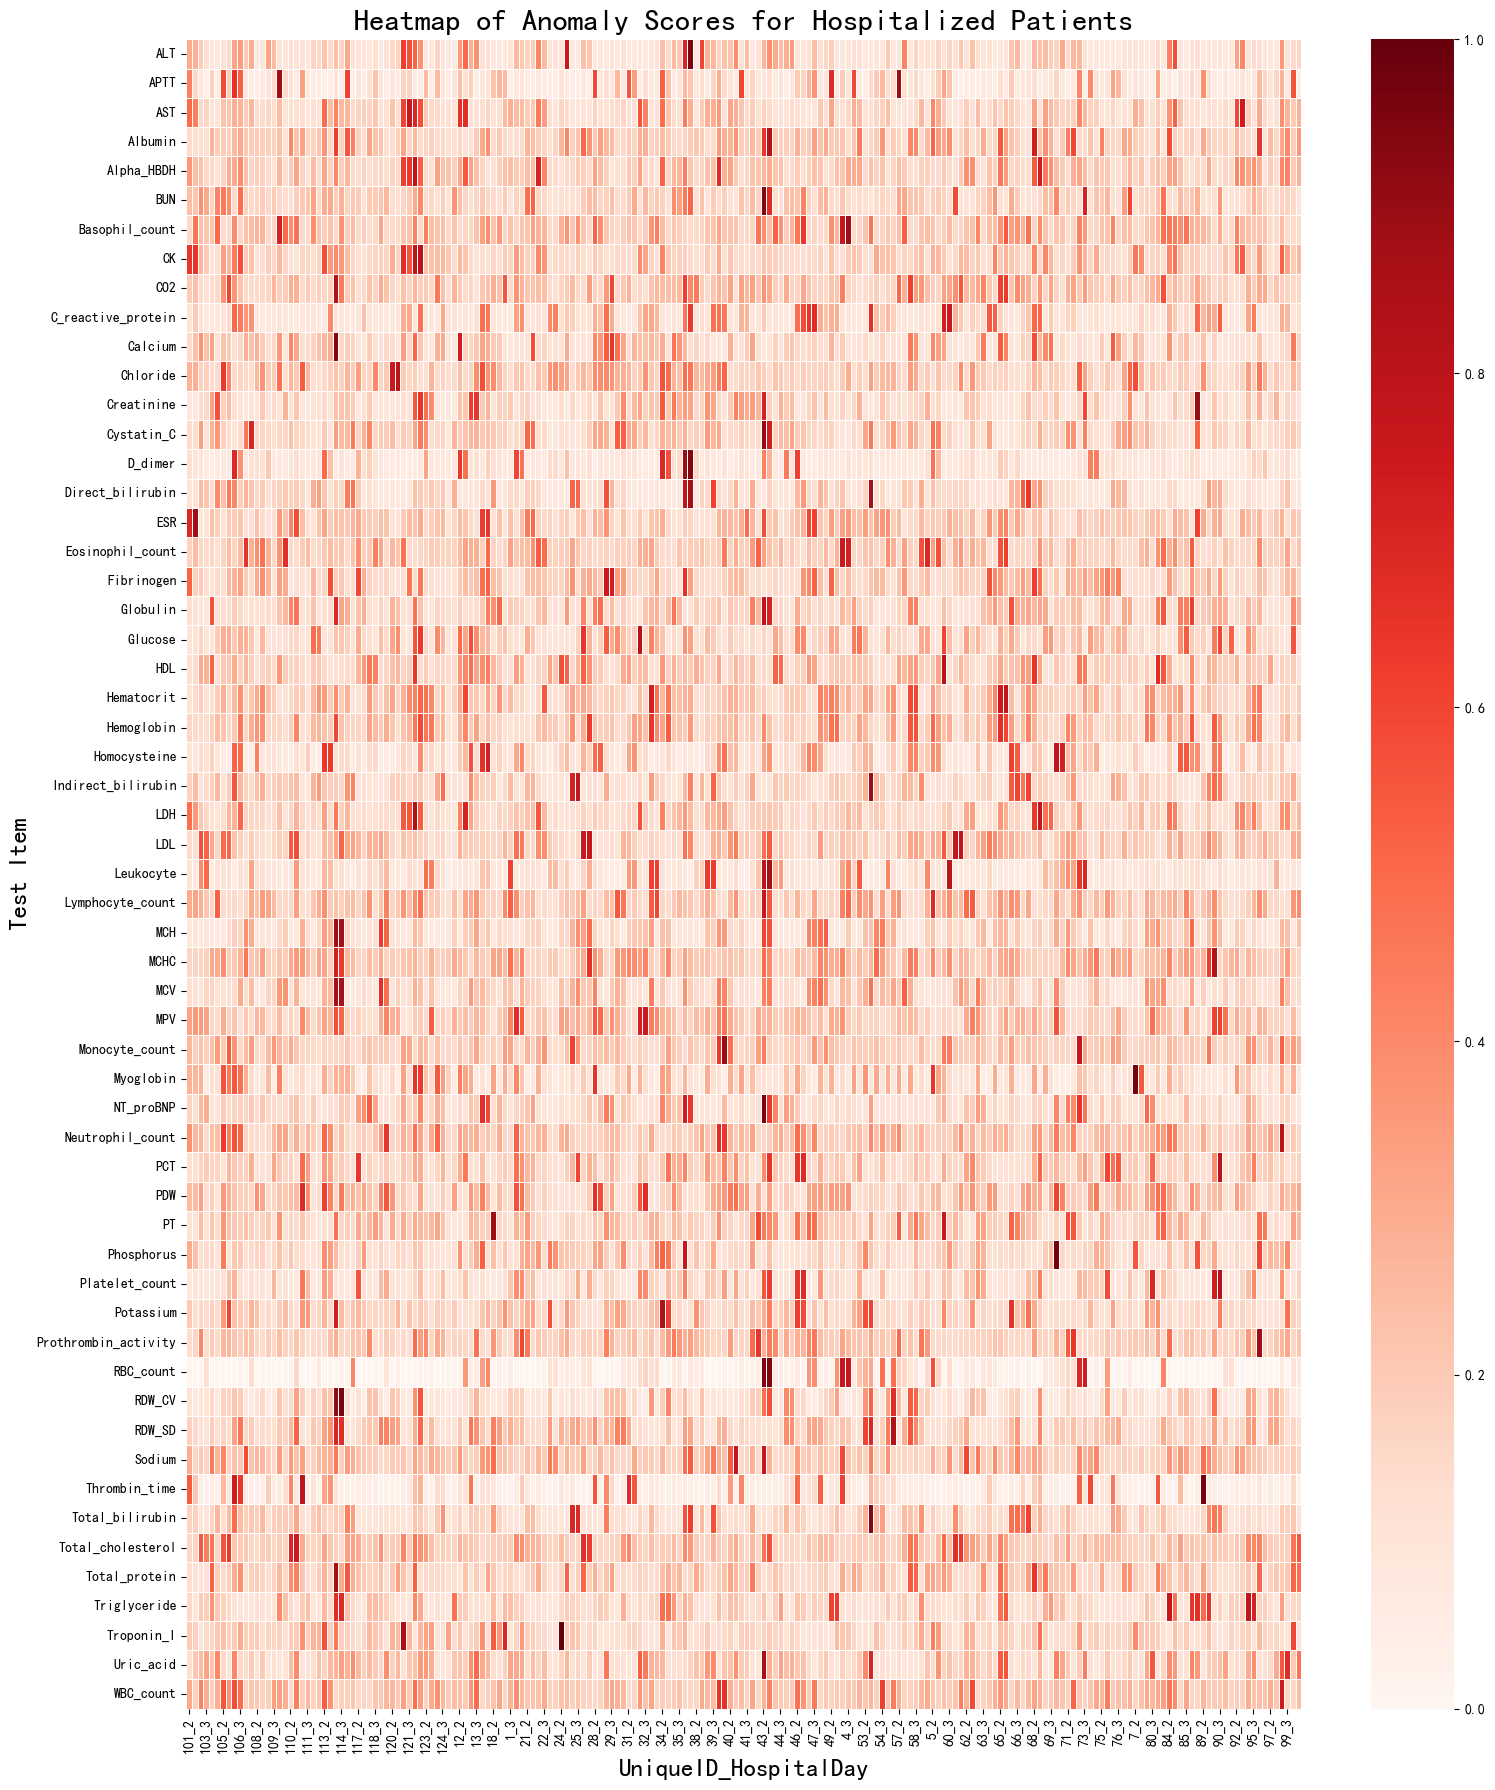

Heatmap saved to: D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\anomaly_heatmap.png


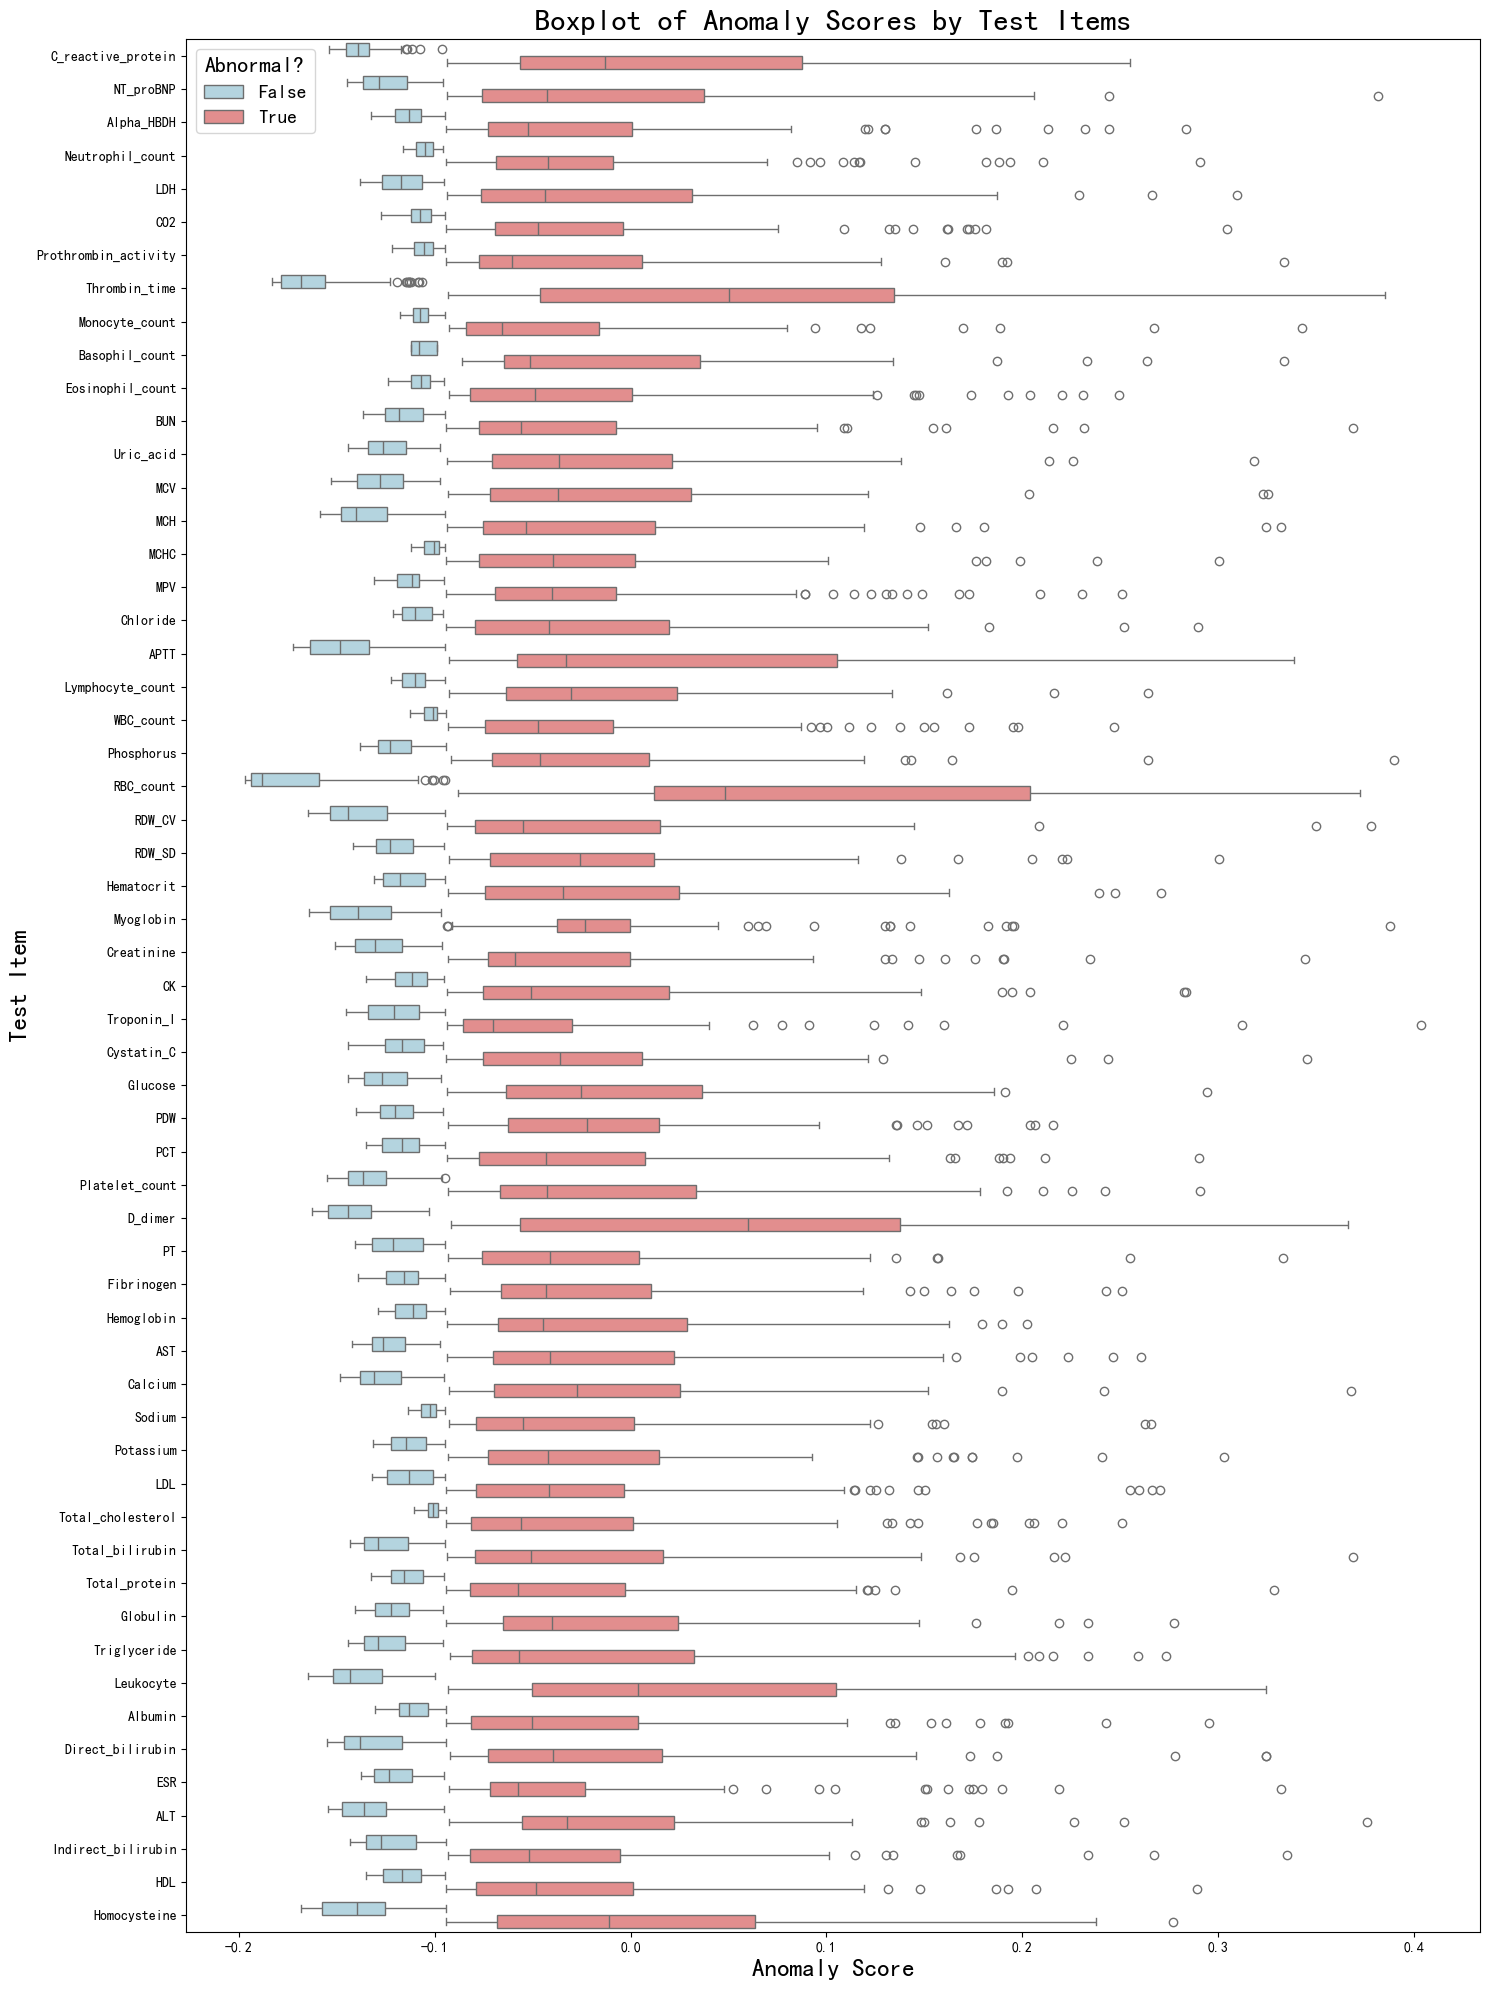

Boxplot saved to: D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\anomaly_boxplot.png


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from matplotlib.font_manager import FontProperties

# ==========================
# 1. 数据加载与预处理
# ==========================

# 定义文件路径
data_path = r'D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\data_GAN.csv'

# 读取CSV文件
data = pd.read_csv(data_path)

# 在这里定义一个字典，将中文列名映射到英文列名
# （以下示例仅针对给定的列进行翻译，需根据实际业务场景补充或调整）
rename_dict = {
    '日期': 'Date',
    '唯一编号': 'UniqueID',
    '住院日序号': 'HospitalDay',
    '性别': 'Gender',
    '年龄': 'Age',
    '检测项目': 'TestItem',
    'change': 'Change',
    'mean_val': 'MeanVal',
    'var_val': 'VarVal',
    '异常分数': 'AnomalyScore',
    '异常分数标准化': 'AnomalyScore_Normalized',
    '是否异常': 'IsAbnormal',
    # 以下是常见生化指标的示例翻译，可按需补充或修改：
    'C反应蛋白': 'C_reactive_protein',
    'N末端B型钠尿肽原测定': 'NT_proBNP',
    'α羟基丁酸脱氢酶': 'Alpha_HBDH',
    '中性粒细胞绝对值': 'Neutrophil_count',
    '乳酸脱氢酶': 'LDH',
    '二氧化碳': 'CO2',
    '凝血酶原活动度': 'Prothrombin_activity',
    '凝血酶时间测定': 'Thrombin_time',
    '单核细胞绝对值': 'Monocyte_count',
    '嗜碱性粒细胞绝对值': 'Basophil_count',
    '嗜酸性粒细胞绝对值': 'Eosinophil_count',
    '尿素氮': 'BUN',
    '尿酸': 'Uric_acid',
    '平均红细胞体积': 'MCV',
    '平均红细胞血红蛋白含量': 'MCH',
    '平均红细胞血红蛋白浓度': 'MCHC',
    '平均血小板体积': 'MPV',
    '氯': 'Chloride',
    '活化部分凝血活酶时间测定': 'APTT',
    '淋巴细胞绝对值': 'Lymphocyte_count',
    '白细胞数': 'WBC_count',
    '磷': 'Phosphorus',
    '红细胞': 'RBC_count',
    '红细胞体积分布宽度-CV': 'RDW_CV',
    '红细胞体积分布宽度-SD': 'RDW_SD',
    '红细胞压积': 'Hematocrit',
    '肌红蛋白': 'Myoglobin',
    '肌酐': 'Creatinine',
    '肌酸激酶': 'CK',
    '肌钙蛋白I': 'Troponin_I',
    '胱抑素C': 'Cystatin_C',
    '葡萄糖': 'Glucose',
    '血小板体积分布宽度': 'PDW',
    '血小板压积': 'PCT',
    '血小板数': 'Platelet_count',
    '血浆D-二聚体测定': 'D_dimer',
    '血浆凝血酶原时间测定': 'PT',
    '血浆纤维蛋白原测定': 'Fibrinogen',
    '血红蛋白浓度': 'Hemoglobin',
    '谷草转氨酶': 'AST',
    '钙': 'Calcium',
    '钠': 'Sodium',
    '钾': 'Potassium',
    '低密度脂蛋白': 'LDL',
    '总胆固醇': 'Total_cholesterol',
    '总胆红素': 'Total_bilirubin',
    '总蛋白': 'Total_protein',
    '球蛋白': 'Globulin',
    '甘油三酯': 'Triglyceride',
    '白细胞': 'Leukocyte',
    '白蛋白': 'Albumin',
    '直接胆红素': 'Direct_bilirubin',
    '红细胞沉降率': 'ESR',
    '谷丙转氨酶': 'ALT',
    '间接胆红素': 'Indirect_bilirubin',
    '高密度脂蛋白': 'HDL',
    '同型半胱氨酸': 'Homocysteine',
}

# 重命名列
data.rename(columns=rename_dict, inplace=True)

# 查看数据基本信息
print("Data Overview:")
print(data.head())
print("\nData Description:")
print(data.describe())
print("\nData Types:")
print(data.dtypes)

# 排除非特征列
exclude_cols = ['UniqueID', 'Date', 'HospitalDay', 'Gender', 'Age']
feature_cols = [col for col in data.columns if col not in exclude_cols]

# 确保特征列为数值型，并处理缺失值（填充为0或其他策略）
data[feature_cols] = data[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# 查看缺失值情况
print("\nMissing Values:")
print(data[feature_cols].isnull().sum())

# 获取唯一的患者编号和检测项目
unique_ids = data['UniqueID'].unique()
unique_projects = feature_cols  # 每个特征列代表一个检测项目

# ==========================
# 2. 构建滑动窗口特征
# ==========================

window_size = 2  # 2天滑动窗口
window_features = []

for uid in unique_ids:
    patient_data = data[data['UniqueID'] == uid].sort_values('HospitalDay')
    patient_data = patient_data.reset_index(drop=True)
    num_days = patient_data.shape[0]

    # 对每个检测项目应用滑动窗口
    for project in unique_projects:
        project_values = patient_data[project].values

        for i in range(num_days - window_size + 1):
            window = project_values[i:i + window_size]
            day1, day2 = window

            # 计算特征
            change = day2 - day1
            mean_val = np.mean(window)
            var_val = np.var(window)

            # 对应的住院日序号（窗口的第二天）
            hospital_day = patient_data.loc[i + window_size - 1, 'HospitalDay']

            # 存储特征
            window_features.append({
                'UniqueID': uid,
                'TestItem': project,
                'HospitalDay': hospital_day,
                'Change': change,
                'MeanVal': mean_val,
                'VarVal': var_val
            })

features_df = pd.DataFrame(window_features)

print("\nSliding Window Features Overview:")
print(features_df.head())
print("\nSliding Window Features Description:")
print(features_df.describe())

# ==========================
# 3. 训练孤立森林模型并计算异常分数
# ==========================

anomaly_scores_list = []
projects = features_df['TestItem'].unique()

for project in projects:
    print(f"Processing item: {project}")

    project_data = features_df[features_df['TestItem'] == project]
    feature_columns = ['Change', 'MeanVal', 'VarVal']
    X = project_data[feature_columns].values

    if len(X) < 2:
        print(f"Item {project} does not have enough data, skipped.\n")
        continue

    iso = IsolationForest(n_estimators=100, contamination='auto', random_state=123)
    iso.fit(X)

    scores = -iso.decision_function(X)  # 越大越异常
    project_anomaly = project_data.copy()
    project_anomaly['AnomalyScore'] = scores

    anomaly_scores_list.append(project_anomaly)
    print(f"Item {project} anomaly scores calculated.\n")

if anomaly_scores_list:
    anomaly_scores_df = pd.concat(anomaly_scores_list, ignore_index=True)
    print("All items' anomaly scores have been merged.")
    print(f"Total anomaly score data points: {anomaly_scores_df.shape[0]}")
else:
    print("No anomaly scores were calculated.")
    anomaly_scores_df = pd.DataFrame()

# ==========================
# 4. 标准化异常分数
# ==========================

if not anomaly_scores_df.empty:
    scaler = MinMaxScaler()
    anomaly_scores_df['AnomalyScore_Normalized'] = scaler.fit_transform(anomaly_scores_df[['AnomalyScore']])
    print("\nNormalized Anomaly Scores Overview:")
    print(anomaly_scores_df.head())
else:
    print("Anomaly score DataFrame is empty, skipping normalization step.")

# ==========================
# 5. 创建 'UniqueID_HospitalDay' 列
# ==========================

if not anomaly_scores_df.empty:
    anomaly_scores_df['UniqueID_HospitalDay'] = (
        anomaly_scores_df['UniqueID'].astype(str) + '_' + anomaly_scores_df['HospitalDay'].astype(str)
    )
    print("\nCreating 'UniqueID_HospitalDay' column completed.")
    print(anomaly_scores_df[['UniqueID', 'HospitalDay', 'UniqueID_HospitalDay']].head())
else:
    print("Anomaly score DataFrame is empty, skipping 'UniqueID_HospitalDay' creation.")

# ==========================
# 6. 保存异常分数
# ==========================

save_dir = r'D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

save_path = os.path.join(save_dir, 'anomaly_scores_df.csv')
anomaly_scores_df.to_csv(save_path, index=False)
print(f"Anomaly scores saved to: {save_path}")

# ==========================
# 7. 可视化（可选）
# ==========================

if not anomaly_scores_df.empty:
    # 设置字体和负号显示
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 如果需要中文，可以改成英文或注释掉
    plt.rcParams['axes.unicode_minus'] = False

    # 生成热力图
    plt.figure(figsize=(16, 18))
    # pivot表时使用英文列名
    heatmap_data = anomaly_scores_df.pivot(
        index='TestItem', 
        columns='UniqueID_HospitalDay', 
        values='AnomalyScore_Normalized'
    )

    sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, linecolor='white')
    plt.title('Heatmap of Anomaly Scores for Hospitalized Patients', fontsize=22)
    plt.xlabel('UniqueID_HospitalDay', fontsize=18)
    plt.ylabel('Test Item', fontsize=18)
    plt.tight_layout()

    heatmap_save_path = os.path.join(save_dir, 'anomaly_heatmap.png')
    plt.savefig(heatmap_save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"Heatmap saved to: {heatmap_save_path}")

    # 生成箱线图
    plt.figure(figsize=(15, 20))

    # 按中位数划分异常/正常
    median_score = anomaly_scores_df['AnomalyScore'].median()
    anomaly_scores_df['IsAbnormal'] = anomaly_scores_df['AnomalyScore'] > median_score

    sns.boxplot(
        y='TestItem', x='AnomalyScore',
        hue='IsAbnormal', data=anomaly_scores_df,
        palette=['lightblue', 'lightcoral']
    )
    plt.title('Boxplot of Anomaly Scores by Test Items', fontsize=22)
    plt.xlabel('Anomaly Score', fontsize=18)
    plt.ylabel('Test Item', fontsize=18)
    plt.legend(title='Abnormal?', fontsize=14, title_fontsize=16)
    plt.tight_layout()

    boxplot_save_path = os.path.join(save_dir, 'anomaly_boxplot.png')
    plt.savefig(boxplot_save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"Boxplot saved to: {boxplot_save_path}")
else:
    print("Anomaly score DataFrame is empty, skipping visualization.")


Data Overview:
         Date  UniqueID  Gender  Age  C_reactive_protein  NT_proBNP  \
0  2021-10-11         1       1   64                2.04      607.5   
1  2021-10-12         1       1   64                4.40     2475.2   
2  2021-10-13         1       1   64               11.50     2855.7   
3  2021-11-24         3       1   47               47.30     2883.8   
4  2021-11-26         3       1   47              121.20     3600.0   

   Alpha_HBDH  Neutrophil_count      LDH   CO2  ...  Triglyceride  Leukocyte  \
0       676.0              7.71   686.85  28.8  ...          1.53        3.7   
1       926.0              6.47   904.60  23.7  ...          2.61        5.0   
2       596.0              7.49   604.00  22.1  ...          1.58       71.7   
3      2042.0             21.33  1545.50  22.2  ...          0.52        3.8   
4      1060.0             14.15  1177.60  26.0  ...          1.58        2.2   

   Albumin  Direct_bilirubin  ESR   ALT  Indirect_bilirubin   HDL  \
0     41

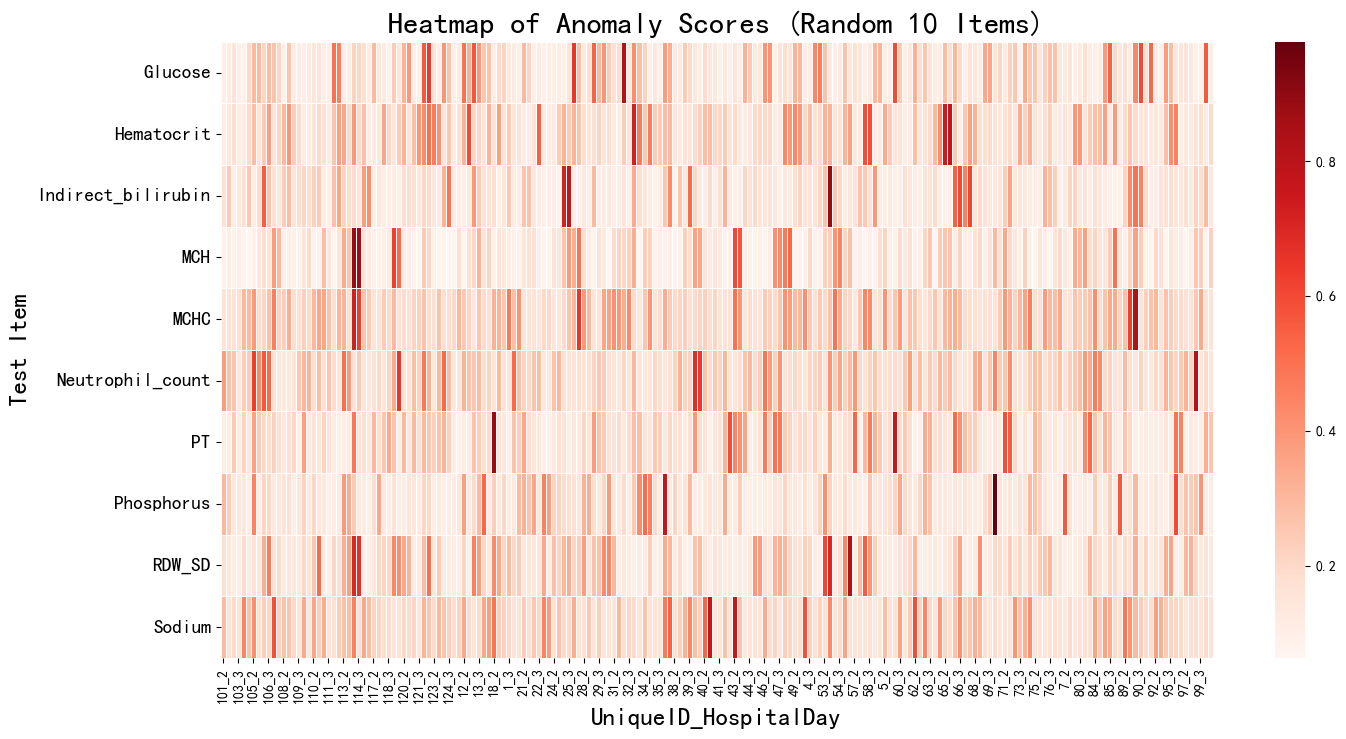

Heatmap (random 10 items) saved to: D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\anomaly_heatmap_random10.png


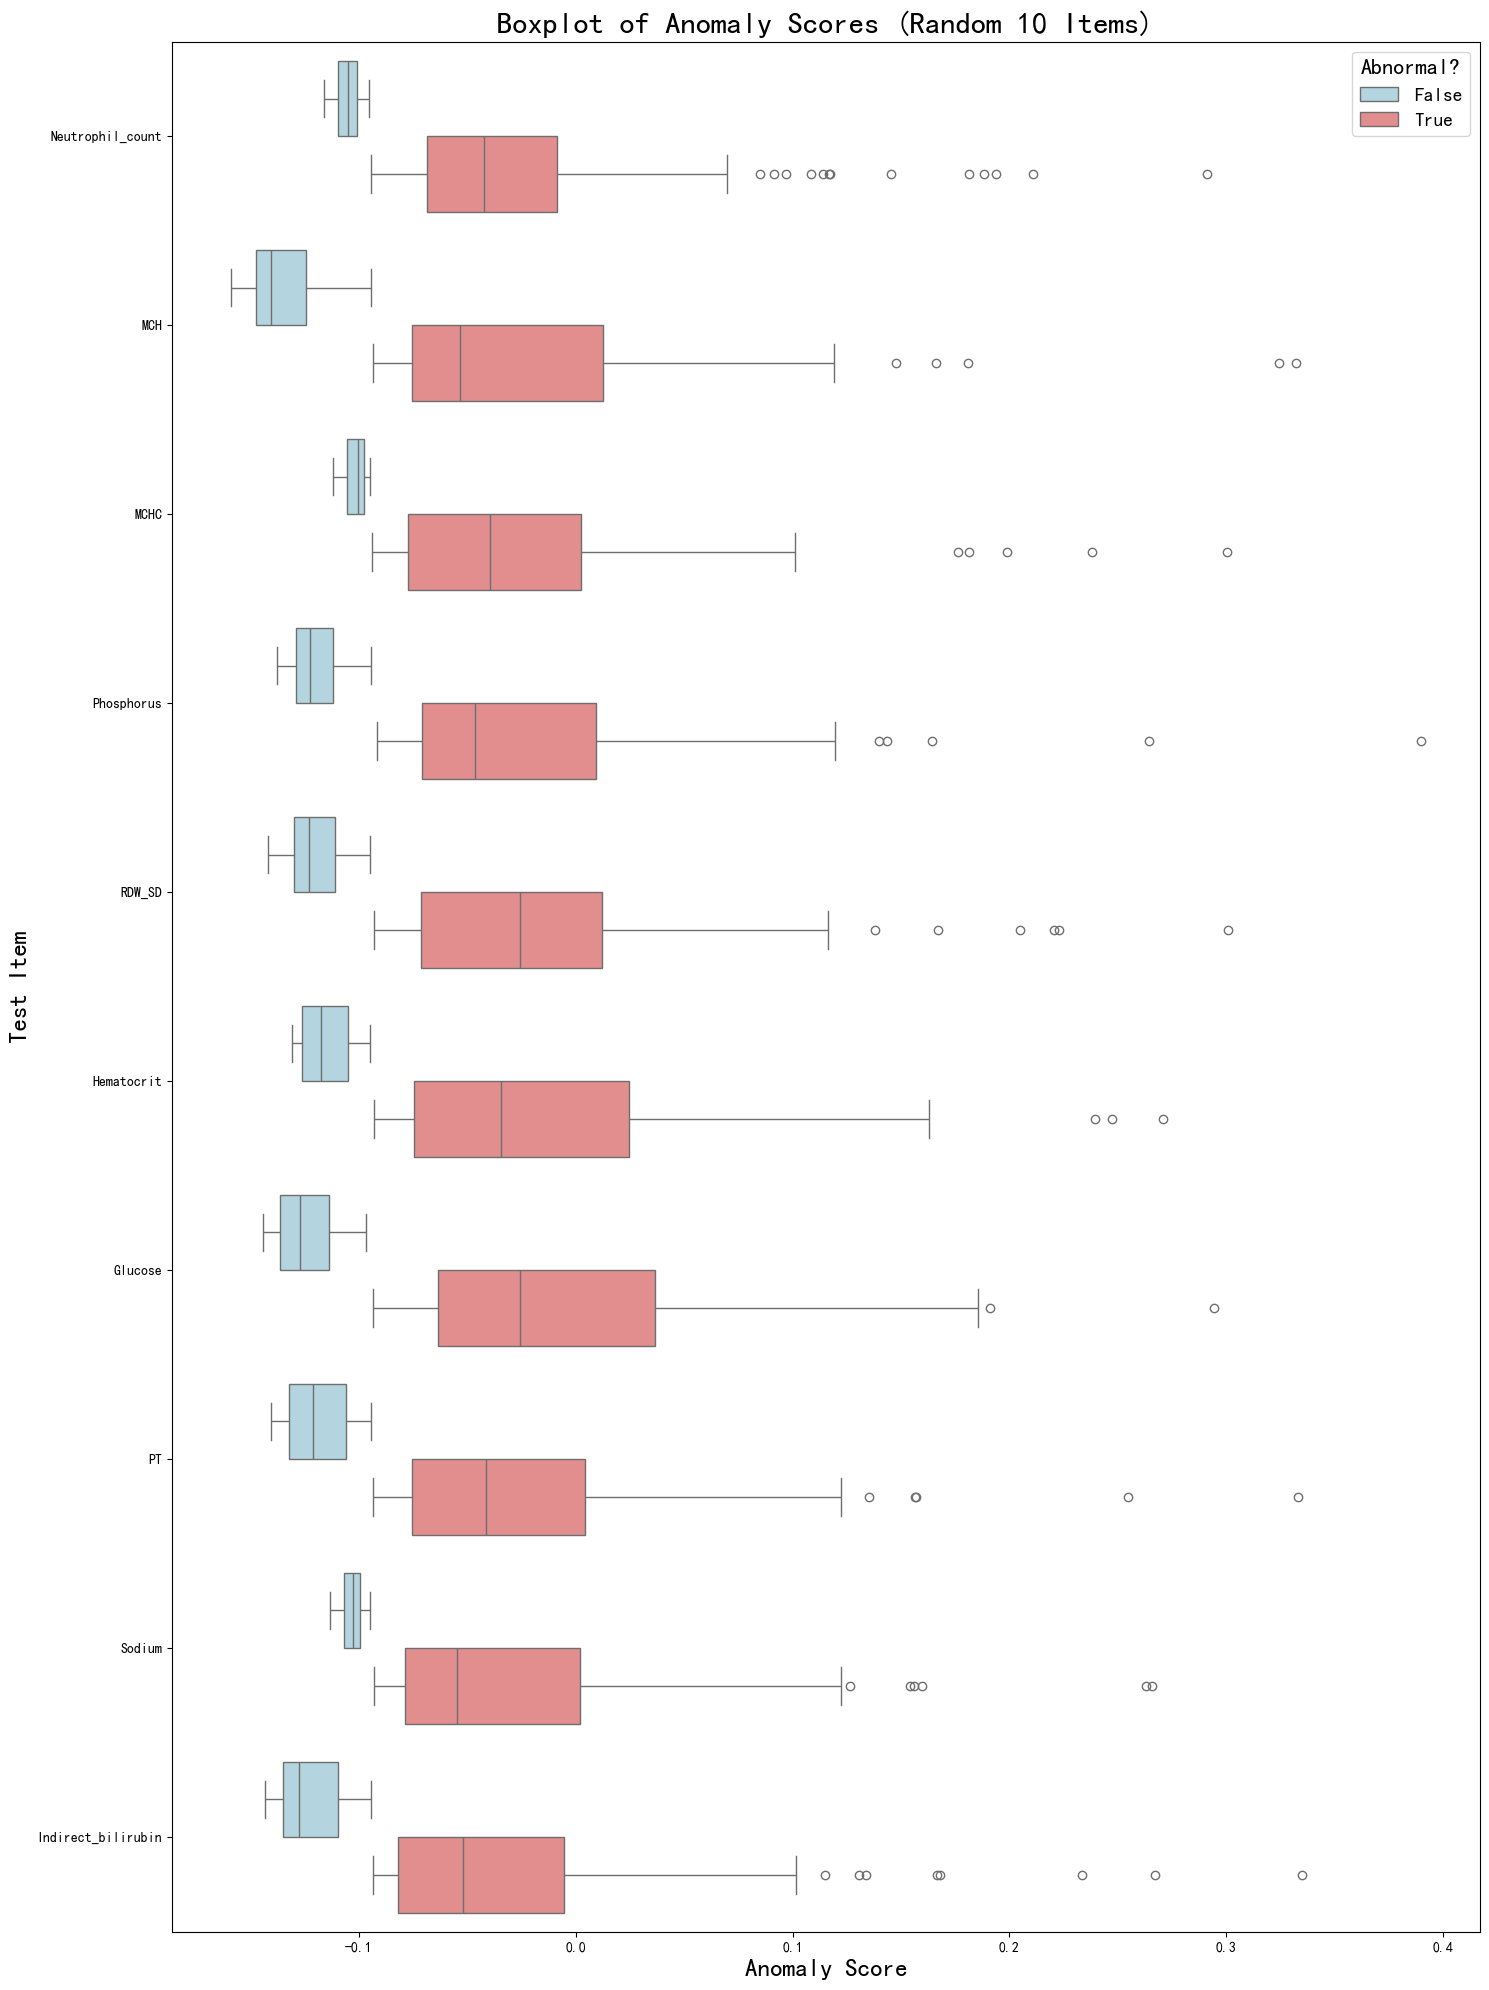

Boxplot (random 10 items) saved to: D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\anomaly_boxplot_random10.png


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# ==========================
# 1. Data Loading & Preprocessing
# ==========================

# Define file path
data_path = r'D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\data_GAN.csv'

# Read CSV
data = pd.read_csv(data_path)

# A dictionary to rename Chinese columns to English
rename_dict = {
    # 关键的住院相关列
    '唯一编号': 'UniqueID',
    '日期': 'Date',
    '住院日序号': 'HospitalDay',
    '性别': 'Gender',
    '年龄': 'Age',
    
    # 下面三个是我们在滑动窗口构建后生成的列，如果原 CSV 没有，可以稍后再 rename
    'change': 'Change',
    'mean_val': 'MeanVal',
    'var_val': 'VarVal',
    
    # 异常分数相关
    '异常分数': 'AnomalyScore',
    '异常分数标准化': 'AnomalyScore_Normalized',
    '是否异常': 'IsAbnormal',
    
    # 常见检验项目 (仅示例，如需更多，请自行补充)
    '检测项目': 'TestItem',
    'C反应蛋白': 'C_reactive_protein',
    'N末端B型钠尿肽原测定': 'NT_proBNP',
    'α羟基丁酸脱氢酶': 'Alpha_HBDH',
    '中性粒细胞绝对值': 'Neutrophil_count',
    '乳酸脱氢酶': 'LDH',
    '二氧化碳': 'CO2',
    '凝血酶原活动度': 'Prothrombin_activity',
    '凝血酶时间测定': 'Thrombin_time',
    '单核细胞绝对值': 'Monocyte_count',
    '嗜碱性粒细胞绝对值': 'Basophil_count',
    '嗜酸性粒细胞绝对值': 'Eosinophil_count',
    '尿素氮': 'BUN',
    '尿酸': 'Uric_acid',
    '平均红细胞体积': 'MCV',
    '平均红细胞血红蛋白含量': 'MCH',
    '平均红细胞血红蛋白浓度': 'MCHC',
    '平均血小板体积': 'MPV',
    '氯': 'Chloride',
    '活化部分凝血活酶时间测定': 'APTT',
    '淋巴细胞绝对值': 'Lymphocyte_count',
    '白细胞数': 'WBC_count',
    '磷': 'Phosphorus',
    '红细胞': 'RBC_count',
    '红细胞体积分布宽度-CV': 'RDW_CV',
    '红细胞体积分布宽度-SD': 'RDW_SD',
    '红细胞压积': 'Hematocrit',
    '肌红蛋白': 'Myoglobin',
    '肌酐': 'Creatinine',
    '肌酸激酶': 'CK',
    '肌钙蛋白I': 'Troponin_I',
    '胱抑素C': 'Cystatin_C',
    '葡萄糖': 'Glucose',
    '血小板体积分布宽度': 'PDW',
    '血小板压积': 'PCT',
    '血小板数': 'Platelet_count',
    '血浆D-二聚体测定': 'D_dimer',
    '血浆凝血酶原时间测定': 'PT',
    '血浆纤维蛋白原测定': 'Fibrinogen',
    '血红蛋白浓度': 'Hemoglobin',
    '谷草转氨酶': 'AST',
    '钙': 'Calcium',
    '钠': 'Sodium',
    '钾': 'Potassium',
    '低密度脂蛋白': 'LDL',
    '总胆固醇': 'Total_cholesterol',
    '总胆红素': 'Total_bilirubin',
    '总蛋白': 'Total_protein',
    '球蛋白': 'Globulin',
    '甘油三酯': 'Triglyceride',
    '白细胞': 'Leukocyte',
    '白蛋白': 'Albumin',
    '直接胆红素': 'Direct_bilirubin',
    '红细胞沉降率': 'ESR',
    '谷丙转氨酶': 'ALT',
    '间接胆红素': 'Indirect_bilirubin',
    '高密度脂蛋白': 'HDL',
    '同型半胱氨酸': 'Homocysteine',
}

# Rename columns to English
data.rename(columns=rename_dict, inplace=True)

# Print data overview
print("Data Overview:")
print(data.head())
print("\nData Description:")
print(data.describe())
print("\nData Types:")
print(data.dtypes)

# Exclude non-feature columns
exclude_cols = ['UniqueID', 'Date', 'HospitalDay', 'Gender', 'Age']
feature_cols = [col for col in data.columns if col not in exclude_cols]

# Ensure the feature columns are numeric, fill NA with 0
data[feature_cols] = data[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

print("\nMissing Values:")
print(data[feature_cols].isnull().sum())

# Unique patients and unique test items
unique_ids = data['UniqueID'].unique()
unique_projects = feature_cols  # each feature col is a test item

# ==========================
# 2. Sliding Window Features
# ==========================

window_size = 2  # 2-day sliding window
window_features = []

for uid in unique_ids:
    patient_data = data[data['UniqueID'] == uid].sort_values('HospitalDay')
    patient_data = patient_data.reset_index(drop=True)
    num_days = patient_data.shape[0]

    for project in unique_projects:
        project_values = patient_data[project].values

        for i in range(num_days - window_size + 1):
            window = project_values[i:i + window_size]
            day1, day2 = window

            change = day2 - day1
            mean_val = np.mean(window)
            var_val = np.var(window)

            # Hospital day for the second day in the window
            hosp_day = patient_data.loc[i + window_size - 1, 'HospitalDay']

            window_features.append({
                'UniqueID': uid,
                'TestItem': project,
                'HospitalDay': hosp_day,
                'Change': change,
                'MeanVal': mean_val,
                'VarVal': var_val
            })

features_df = pd.DataFrame(window_features)

print("\nSliding Window Features Overview:")
print(features_df.head())
print("\nSliding Window Features Description:")
print(features_df.describe())

# ==========================
# 3. Train Isolation Forest and compute anomaly scores
# ==========================

anomaly_scores_list = []
projects = features_df['TestItem'].unique()

for project in projects:
    print(f"Processing item: {project}")

    project_data = features_df[features_df['TestItem'] == project]
    feature_columns = ['Change', 'MeanVal', 'VarVal']
    X = project_data[feature_columns].values

    if len(X) < 2:
        print(f"Item {project} does not have enough data, skipped.\n")
        continue

    iso = IsolationForest(n_estimators=100, contamination='auto', random_state=123)
    iso.fit(X)

    # convert smaller decision_function to bigger anomaly scores
    scores = -iso.decision_function(X)

    project_anomaly = project_data.copy()
    project_anomaly['AnomalyScore'] = scores

    anomaly_scores_list.append(project_anomaly)
    print(f"Item {project} anomaly scores calculated.\n")

if anomaly_scores_list:
    anomaly_scores_df = pd.concat(anomaly_scores_list, ignore_index=True)
    print("All items' anomaly scores have been merged.")
    print(f"Total anomaly score data points: {anomaly_scores_df.shape[0]}")
else:
    print("No anomaly scores were calculated.")
    anomaly_scores_df = pd.DataFrame()

# ==========================
# 4. Normalize anomaly scores
# ==========================
if not anomaly_scores_df.empty:
    scaler = MinMaxScaler()
    anomaly_scores_df['AnomalyScore_Normalized'] = scaler.fit_transform(
        anomaly_scores_df[['AnomalyScore']]
    )
    print("\nNormalized Anomaly Scores Overview:")
    print(anomaly_scores_df.head())
else:
    print("Anomaly score DataFrame is empty, skipping normalization step.")

# ==========================
# 5. Create 'UniqueID_HospitalDay' column
# ==========================
if not anomaly_scores_df.empty:
    anomaly_scores_df['UniqueID_HospitalDay'] = (
        anomaly_scores_df['UniqueID'].astype(str) 
        + '_' + anomaly_scores_df['HospitalDay'].astype(str)
    )
    print("\nCreated 'UniqueID_HospitalDay' column.")
    print(anomaly_scores_df[['UniqueID', 'HospitalDay', 'UniqueID_HospitalDay']].head())
else:
    print("Anomaly score DataFrame is empty, skipping this step.")

# ==========================
# 6. Save anomaly scores
# ==========================
save_dir = r'D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

save_path = os.path.join(save_dir, 'anomaly_scores_df.csv')
anomaly_scores_df.to_csv(save_path, index=False)
print(f"Anomaly scores saved to: {save_path}")

# ==========================
# 7. Visualization (English) -- randomly select 10 items
# ==========================
if not anomaly_scores_df.empty:
    # Optional: if you want to support Chinese characters somewhere
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    # Randomly select 10 test items (if less than 10, select all)
    all_test_items = anomaly_scores_df['TestItem'].unique()
    if len(all_test_items) > 10:
        selected_items = np.random.choice(all_test_items, 10, replace=False)
    else:
        selected_items = all_test_items

    subset_df = anomaly_scores_df[anomaly_scores_df['TestItem'].isin(selected_items)]

    # --- Heatmap ---
    plt.figure(figsize=(16, 8))
    heatmap_data = subset_df.pivot(
        index='TestItem',
        columns='UniqueID_HospitalDay',
        values='AnomalyScore_Normalized'
    )

    sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, linecolor='white')
    plt.title('Heatmap of Anomaly Scores (Random 10 Items)', fontsize=22)
    plt.xlabel('UniqueID_HospitalDay', fontsize=18)
    plt.ylabel('Test Item', fontsize=18)
    plt.yticks(rotation=0, fontsize=14)

    heatmap_save_path = os.path.join(save_dir, 'anomaly_heatmap_random10.png')
    plt.savefig(heatmap_save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"Heatmap (random 10 items) saved to: {heatmap_save_path}")

    # --- Boxplot ---
    plt.figure(figsize=(15, 20))

    # Determine abnormal vs. normal by median
    median_score = anomaly_scores_df['AnomalyScore'].median()
    anomaly_scores_df['IsAbnormal'] = anomaly_scores_df['AnomalyScore'] > median_score

    sns.boxplot(
        y='TestItem', 
        x='AnomalyScore',
        hue='IsAbnormal',
        data=anomaly_scores_df[anomaly_scores_df['TestItem'].isin(selected_items)],
        palette=['lightblue', 'lightcoral']
    )
    plt.title('Boxplot of Anomaly Scores (Random 10 Items)', fontsize=22)
    plt.xlabel('Anomaly Score', fontsize=18)
    plt.ylabel('Test Item', fontsize=18)
    plt.legend(title='Abnormal?', fontsize=14, title_fontsize=16)
    plt.tight_layout()

    boxplot_save_path = os.path.join(save_dir, 'anomaly_boxplot_random10.png')
    plt.savefig(boxplot_save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"Boxplot (random 10 items) saved to: {boxplot_save_path}")
else:
    print("Anomaly score DataFrame is empty, skipping visualization.")
